In [168]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model

from PIL import Image
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

## Generate a keras Dataset

In [66]:
data_fld = '/home/ahoag/ML/mars/attempt1/images_for_cnn_100x100/'
test_fld = '/home/ahoag/ML/mars/attempt1/test_cnn_100x100/'

In [72]:
def load_dataset(batch_size,image_size):

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_fld,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
        class_names=['no_craters','craters']
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_fld,
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
        class_names=['no_craters','craters']
    )
    return train_ds, val_ds

In [73]:
def load_testset(batch_size,image_size):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_fld,
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
        class_names=['no_craters','craters']
    )
    return test_ds

In [90]:
# define cnn model
def single_vggblock_model(input_shape):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255))
    model.add(Conv2D(32, (3, 3), 
                     activation='relu',
                     kernel_initializer='he_uniform',
                     padding='same',
                     input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [94]:
def run_test_harness(model_name):
    # load dataset
    image_size = (100,100)
    n_channels = 3
    input_shape = image_size + (n_channels,)
    batch_size = 32
    epochs = 25
    train_ds, val_ds = load_dataset(batch_size=batch_size,image_size=image_size)
    test_ds = load_testset(batch_size=batch_size,image_size=image_size)
    # Prefetch data -- this will preload other batches' data while current batch data are being processed
    # might only work with GPU but worth including
    train_ds = train_ds.prefetch(buffer_size=32)
    val_ds = val_ds.prefetch(buffer_size=32)
    # prepare pixel data
    
    # define model
    model = single_vggblock_model(input_shape=input_shape)
    # fit model
    savedir = os.path.join('../baseline_model','cnn_saved_epochs',model_name)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(savedir,"model_epoch_{epoch}.h5")),
    ]

    history = model.fit(
        train_ds, 
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds)
    # find best model - one that has best validation accuracy 
    # OK to use accuracy here because datasets are balances
    # Could use ROC AUC as well
    max_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(max_val_acc)+1 
    print(f"Best epoch is {best_epoch} with validation accuracy: {max_val_acc}")
    # load best model from savefile
    save_file = f'{savedir}/model_epoch_{best_epoch}.h5'
    print(f"Loading best model from file: {save_file}")
    best_model = keras.models.load_model(save_file)
    test_loss,test_accuracy = best_model.evaluate(test_ds)
    print(f'Accuracy on test set: {test_accuracy:.3f}')
    return history

In [95]:
history = run_test_harness('single_vggblock')

Found 2024 files belonging to 2 classes.
Using 1620 files for training.
Found 2024 files belonging to 2 classes.
Using 404 files for validation.
Found 419 files belonging to 2 classes.
Epoch 1/25
51/51 [==============================] - 11s 201ms/step - loss: 0.8616 - accuracy: 0.5032 - val_loss: 0.6918 - val_accuracy: 0.5248
Epoch 2/25
51/51 [==============================] - 11s 206ms/step - loss: 0.6922 - accuracy: 0.5092 - val_loss: 0.6937 - val_accuracy: 0.4926
Epoch 3/25
51/51 [==============================] - 10s 201ms/step - loss: 0.6932 - accuracy: 0.5146 - val_loss: 0.6910 - val_accuracy: 0.5173
Epoch 4/25
51/51 [==============================] - 10s 199ms/step - loss: 0.6901 - accuracy: 0.5134 - val_loss: 0.6891 - val_accuracy: 0.5248
Epoch 5/25
51/51 [==============================] - 10s 201ms/step - loss: 0.6885 - accuracy: 0.5300 - val_loss: 0.6853 - val_accuracy: 0.5743
Epoch 6/25
51/51 [==============================] - 10s 201ms/step - loss: 0.6853 - accuracy: 0.5593

In [105]:
def summarize_diagnostics(history):
    # plot loss
    fontsize=14
    fig = plt.figure(figsize=(8,8))
    ax_loss = plt.subplot(211)
    ax_loss.plot(history.history['loss'], color='blue', label='train')
    ax_loss.plot(history.history['val_loss'], color='orange', label='val')
    ax_loss.set_ylabel("Cross Entropy Loss",fontsize=fontsize)
    ax_loss.legend(fontsize=14)
    # plot accuracy
    ax_acc= plt.subplot(212,sharex=ax_loss)
    ax_acc.plot(history.history['accuracy'], color='blue', label='train')
    ax_acc.plot(history.history['val_accuracy'], color='orange', label='val')
    ax_acc.set_xlabel("Epoch",fontsize=fontsize)
    ax_acc.set_ylabel('Classification Accuracy',fontsize=fontsize)
    ax_acc.legend(fontsize=14)

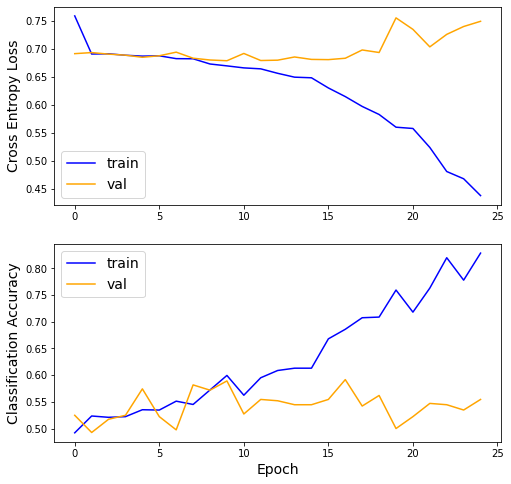

In [106]:
summarize_diagnostics(history)

Classic overfitting. Try a more complex model.

In [122]:
# define cnn model
def two_vggblock_model(input_shape=input_shape):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255,input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), 
                     activation='relu',
                     kernel_initializer='he_uniform',
                     padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

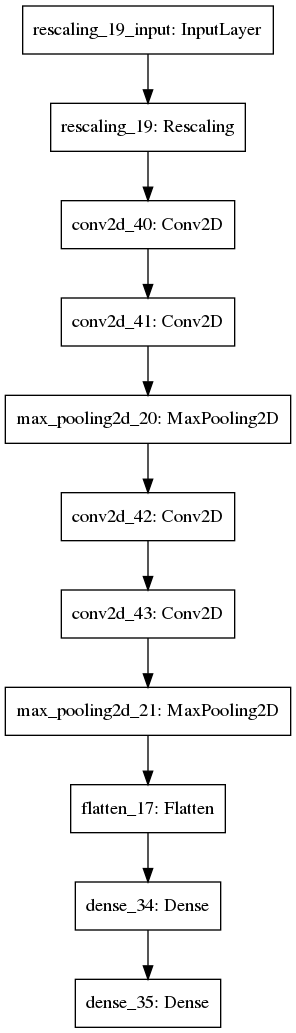

In [123]:
model = two_vggblock_model()
plot_model(model)

In [124]:
def run_test_harness(model_name):
    # load dataset
    image_size = (100,100)
    n_channels = 3
    input_shape = image_size + (n_channels,)
    batch_size = 32
    epochs = 25
    train_ds, val_ds = load_dataset(batch_size=batch_size,image_size=image_size)
    test_ds = load_testset(batch_size=batch_size,image_size=image_size)
    # Prefetch data -- this will preload other batches' data while current batch data are being processed
    # might only work with GPU but worth including
    train_ds = train_ds.prefetch(buffer_size=32)
    val_ds = val_ds.prefetch(buffer_size=32)
    # prepare pixel data
    
    # define model
    model = two_vggblock_model(input_shape=input_shape)
    # fit model
    savedir = os.path.join('../baseline_model','cnn_saved_epochs',model_name)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(savedir,"model_epoch_{epoch}.h5")),
    ]

    history = model.fit(
        train_ds, 
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds)
    # find best model - one that has best validation accuracy 
    # OK to use accuracy here because datasets are balances
    # Could use ROC AUC as well
    max_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(max_val_acc)+1 
    print(f"Best epoch is {best_epoch} with validation accuracy: {max_val_acc}")
    # load best model from savefile
    save_file = f'{savedir}/model_epoch_{best_epoch}.h5'
    print(f"Loading best model from file: {save_file}")
    best_model = keras.models.load_model(save_file)
    test_loss,test_accuracy = best_model.evaluate(test_ds)
    print(f'Accuracy on test set: {test_accuracy:.3f}')
    return history

In [125]:
twovgg_history = run_test_harness(model_name='two_vggblock')

Found 2024 files belonging to 2 classes.
Using 1620 files for training.
Found 2024 files belonging to 2 classes.
Using 404 files for validation.
Found 419 files belonging to 2 classes.
Epoch 1/25
51/51 [==============================] - 16s 310ms/step - loss: 0.8557 - accuracy: 0.4776 - val_loss: 0.6914 - val_accuracy: 0.5149
Epoch 2/25
51/51 [==============================] - 16s 312ms/step - loss: 0.6929 - accuracy: 0.4907 - val_loss: 0.6959 - val_accuracy: 0.4975
Epoch 3/25
51/51 [==============================] - 16s 314ms/step - loss: 0.6932 - accuracy: 0.5190 - val_loss: 0.6886 - val_accuracy: 0.5569
Epoch 4/25
51/51 [==============================] - 16s 313ms/step - loss: 0.6864 - accuracy: 0.5439 - val_loss: 0.6889 - val_accuracy: 0.5149
Epoch 5/25
51/51 [==============================] - 16s 312ms/step - loss: 0.6853 - accuracy: 0.5449 - val_loss: 0.6843 - val_accuracy: 0.5668
Epoch 6/25
51/51 [==============================] - 16s 317ms/step - loss: 0.6796 - accuracy: 0.5717

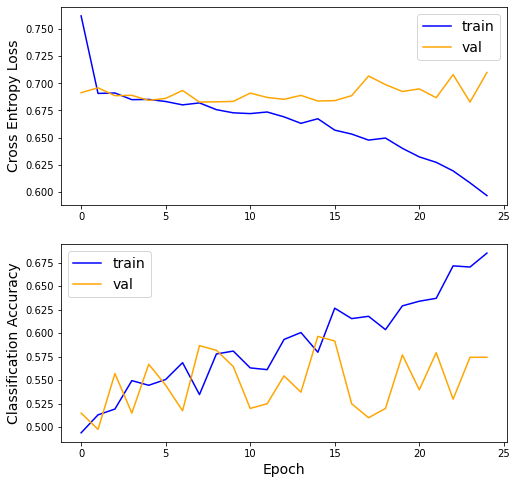

In [127]:
summarize_diagnostics(twovgg_history)

Still overfitting

# Try 3 VGG block model

In [130]:
# define cnn model
def three_vggblock_model(input_shape=input_shape):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255,input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), 
                     activation='relu',
                     kernel_initializer='he_uniform',
                     padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [131]:
def run_test_harness(model_name):
    # load dataset
    image_size = (100,100)
    n_channels = 3
    input_shape = image_size + (n_channels,)
    batch_size = 32
    epochs = 25
    train_ds, val_ds = load_dataset(batch_size=batch_size,image_size=image_size)
    test_ds = load_testset(batch_size=batch_size,image_size=image_size)
    # Prefetch data -- this will preload other batches' data while current batch data are being processed
    # might only work with GPU but worth including
    train_ds = train_ds.prefetch(buffer_size=32)
    val_ds = val_ds.prefetch(buffer_size=32)
    # prepare pixel data
    
    # define model
    model = three_vggblock_model(input_shape=input_shape)
    # fit model
    savedir = os.path.join('../baseline_model','cnn_saved_epochs',model_name)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(savedir,"model_epoch_{epoch}.h5")),
    ]

    history = model.fit(
        train_ds, 
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds)
    # find best model - one that has best validation accuracy 
    # OK to use accuracy here because datasets are balances
    # Could use ROC AUC as well
    max_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(max_val_acc)+1 
    print(f"Best epoch is {best_epoch} with validation accuracy: {max_val_acc}")
    # load best model from savefile
    save_file = f'{savedir}/model_epoch_{best_epoch}.h5'
    print(f"Loading best model from file: {save_file}")
    best_model = keras.models.load_model(save_file)
    test_loss,test_accuracy = best_model.evaluate(test_ds)
    print(f'Accuracy on test set: {test_accuracy:.3f}')
    return history

In [132]:
threevgg_history = run_test_harness(model_name='three_vggblock')

Found 2024 files belonging to 2 classes.
Using 1620 files for training.
Found 2024 files belonging to 2 classes.
Using 404 files for validation.
Found 419 files belonging to 2 classes.
Epoch 1/25
51/51 [==============================] - 19s 363ms/step - loss: 0.7916 - accuracy: 0.5058 - val_loss: 0.6915 - val_accuracy: 0.5124
Epoch 2/25
51/51 [==============================] - 18s 358ms/step - loss: 0.6944 - accuracy: 0.5276 - val_loss: 0.6917 - val_accuracy: 0.5099
Epoch 3/25
51/51 [==============================] - 19s 363ms/step - loss: 0.6909 - accuracy: 0.5237 - val_loss: 0.6853 - val_accuracy: 0.5916
Epoch 4/25
51/51 [==============================] - 19s 361ms/step - loss: 0.6864 - accuracy: 0.5363 - val_loss: 0.6863 - val_accuracy: 0.5396
Epoch 5/25
51/51 [==============================] - 18s 361ms/step - loss: 0.6838 - accuracy: 0.5518 - val_loss: 0.6844 - val_accuracy: 0.5619
Epoch 6/25
51/51 [==============================] - 18s 361ms/step - loss: 0.6799 - accuracy: 0.5584

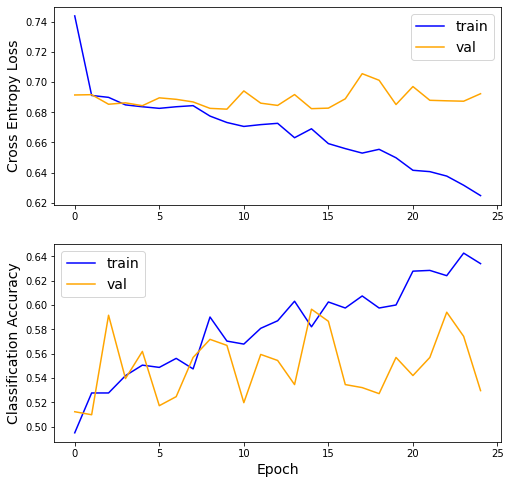

In [133]:
summarize_diagnostics(threevgg_history)

Looks basically same as twovgg. Still overfitting. Can see that as we add model complexity the training curve is slowing down - it is still improving but compared to the simplest model the learning is slower. Model overfits pretty much right away. 

## Regularization technique 1: Add Dropout() layers

In [138]:
# define cnn model
def three_vggblock_dropout_model(input_shape=input_shape):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255,input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), 
                     activation='relu',
                     kernel_initializer='he_uniform',
                     padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [139]:
def run_test_harness(model_name):
    # load dataset
    image_size = (100,100)
    n_channels = 3
    input_shape = image_size + (n_channels,)
    batch_size = 32
    epochs = 25
    train_ds, val_ds = load_dataset(batch_size=batch_size,image_size=image_size)
    test_ds = load_testset(batch_size=batch_size,image_size=image_size)
    # Prefetch data -- this will preload other batches' data while current batch data are being processed
    # might only work with GPU but worth including
    train_ds = train_ds.prefetch(buffer_size=32)
    val_ds = val_ds.prefetch(buffer_size=32)    
    # define model
    model = three_vggblock_dropout_model(input_shape=input_shape)
    # fit model
    savedir = os.path.join('../baseline_model','cnn_saved_epochs',model_name)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(savedir,"model_epoch_{epoch}.h5")),
    ]

    history = model.fit(
        train_ds, 
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds)
    # find best model - one that has best validation accuracy 
    # OK to use accuracy here because datasets are balances
    # Could use ROC AUC as well
    max_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(max_val_acc)+1 
    print(f"Best epoch is {best_epoch} with validation accuracy: {max_val_acc}")
    # load best model from savefile
    save_file = f'{savedir}/model_epoch_{best_epoch}.h5'
    print(f"Loading best model from file: {save_file}")
    best_model = keras.models.load_model(save_file)
    test_loss,test_accuracy = best_model.evaluate(test_ds)
    print(f'Accuracy on test set: {test_accuracy:.3f}')
    return history

In [140]:
history_threevgg_dropout = run_test_harness(model_name='three_vggblock_dropout')

Found 2024 files belonging to 2 classes.
Using 1620 files for training.
Found 2024 files belonging to 2 classes.
Using 404 files for validation.
Found 419 files belonging to 2 classes.
Epoch 1/25
51/51 [==============================] - 20s 378ms/step - loss: 1.1014 - accuracy: 0.4885 - val_loss: 0.6935 - val_accuracy: 0.4480
Epoch 2/25
51/51 [==============================] - 19s 376ms/step - loss: 0.6937 - accuracy: 0.5058 - val_loss: 0.6933 - val_accuracy: 0.4975
Epoch 3/25
51/51 [==============================] - 19s 374ms/step - loss: 0.6973 - accuracy: 0.4818 - val_loss: 0.6928 - val_accuracy: 0.5099
Epoch 4/25
51/51 [==============================] - 19s 374ms/step - loss: 0.6932 - accuracy: 0.5084 - val_loss: 0.6927 - val_accuracy: 0.5371
Epoch 5/25
51/51 [==============================] - 19s 376ms/step - loss: 0.6933 - accuracy: 0.5148 - val_loss: 0.6925 - val_accuracy: 0.5124
Epoch 6/25
51/51 [==============================] - 19s 372ms/step - loss: 0.6957 - accuracy: 0.4632

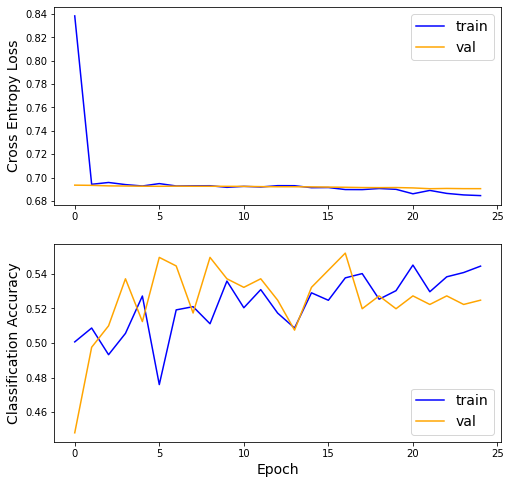

In [141]:
 summarize_diagnostics(history_threevgg_dropout)

Well, at least it isn't obviously overfitting anymore... It is not learning especially well now though. It's possible that is over-regularization -- it provides too much constraint that the model can no longer learn. Could try decreasing dropout fraction since my trainval size is small! I could try more epochs or add dropouts to the simpler model that seemed to train better over this short number of epochs. Let's first try ~25 more epochs.

In [148]:
last_file = '../baseline_model/cnn_saved_epochs/three_vggblock_dropout/model_epoch_25.h5'
last_model = keras.models.load_model(last_file)
model_name='three_vggblock_dropout'
image_size = (100,100)
n_channels = 3
input_shape = image_size + (n_channels,)
batch_size = 32
epochs = 25
train_ds, val_ds = load_dataset(batch_size=batch_size,image_size=image_size)
test_ds = load_testset(batch_size=batch_size,image_size=image_size)
# Prefetch data -- this will preload other batches' data while current batch data are being processed
# might only work with GPU but worth including
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)    
# define model
# fit model
savedir = os.path.join('../baseline_model','cnn_saved_epochs',model_name)
if not os.path.exists(savedir):
    os.mkdir(savedir)
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(savedir,"model_epoch_{epoch}_contd.h5")),
]

history_threevgg_dropout_contd = last_model.fit(
train_ds, 
epochs=epochs,
callbacks=callbacks,
validation_data=val_ds)
    # find best model -

Found 2024 files belonging to 2 classes.
Using 1620 files for training.
Found 2024 files belonging to 2 classes.
Using 404 files for validation.
Found 419 files belonging to 2 classes.
Epoch 1/25
51/51 [==============================] - 20s 377ms/step - loss: 0.6817 - accuracy: 0.5364 - val_loss: 0.6908 - val_accuracy: 0.5149
Epoch 2/25
51/51 [==============================] - 19s 380ms/step - loss: 0.6825 - accuracy: 0.5352 - val_loss: 0.6905 - val_accuracy: 0.5272
Epoch 3/25
51/51 [==============================] - 19s 379ms/step - loss: 0.6832 - accuracy: 0.5309 - val_loss: 0.6907 - val_accuracy: 0.5223
Epoch 4/25
51/51 [==============================] - 19s 373ms/step - loss: 0.6819 - accuracy: 0.5414 - val_loss: 0.6906 - val_accuracy: 0.5272
Epoch 5/25
51/51 [==============================] - 19s 378ms/step - loss: 0.6811 - accuracy: 0.5543 - val_loss: 0.6906 - val_accuracy: 0.5322
Epoch 6/25
51/51 [==============================] - 19s 369ms/step - loss: 0.6842 - accuracy: 0.5210

## Regularization technique 2: Data Augmentation

In [150]:
# define cnn model
def two_vggblock_dataaug_model(input_shape=input_shape):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255,input_shape=input_shape))
    model.add(layers.experimental.preprocessing.RandomFlip("horizontal"))
    model.add(layers.experimental.preprocessing.RandomRotation(0.1))
    model.add(Conv2D(32, (3, 3), 
                     activation='relu',
                     kernel_initializer='he_uniform',
                     padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [163]:
def run_test_harness(model_name,model_fn,epochs=40):
    # load dataset
    image_size = (100,100)
    n_channels = 3
    input_shape = image_size + (n_channels,)
    print(f"Input shape: {input_shape}")
    batch_size = 32
    train_ds, val_ds = load_dataset(batch_size=batch_size,image_size=image_size)
    test_ds = load_testset(batch_size=batch_size,image_size=image_size)
    # Prefetch data -- this will preload other batches' data while current batch data are being processed
    # might only work with GPU but worth including
    train_ds = train_ds.prefetch(buffer_size=32)
    val_ds = val_ds.prefetch(buffer_size=32)    
    # define model
    model = model_fn(input_shape=input_shape)
    # fit model
    savedir = os.path.join('../baseline_model','cnn_saved_epochs',model_name)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    callbacks = [
        keras.callbacks.ModelCheckpoint(os.path.join(savedir,"model_epoch_{epoch}.h5")),
    ]

    history = model.fit(
        train_ds, 
        epochs=epochs,
        callbacks=callbacks,
        validation_data=val_ds)
    # find best model - one that has best validation accuracy 
    # OK to use accuracy here because datasets are balances
    # Could use ROC AUC as well
    max_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(max_val_acc)+1 
    print(f"Best epoch is {best_epoch} with validation accuracy: {max_val_acc}")
    # load best model from savefile
    save_file = f'{savedir}/model_epoch_{best_epoch}.h5'
    print(f"Loading best model from file: {save_file}")
    best_model = keras.models.load_model(save_file)
    test_loss,test_accuracy = best_model.evaluate(test_ds)
    print(f'Accuracy on test set: {test_accuracy:.3f}')
    return history

In [152]:
history_twovgg_dataaug = run_test_harness('two_vggblock_dataaug',two_vggblock_dataaug_model)

Found 2024 files belonging to 2 classes.
Using 1620 files for training.
Found 2024 files belonging to 2 classes.
Using 404 files for validation.
Found 419 files belonging to 2 classes.
Epoch 1/40
51/51 [==============================] - 17s 316ms/step - loss: 0.8432 - accuracy: 0.5150 - val_loss: 0.6931 - val_accuracy: 0.4926
Epoch 2/40
51/51 [==============================] - 16s 321ms/step - loss: 0.6924 - accuracy: 0.5063 - val_loss: 0.6893 - val_accuracy: 0.5223
Epoch 3/40
51/51 [==============================] - 16s 319ms/step - loss: 0.6893 - accuracy: 0.5259 - val_loss: 0.6894 - val_accuracy: 0.5569
Epoch 4/40
51/51 [==============================] - 16s 318ms/step - loss: 0.6898 - accuracy: 0.5233 - val_loss: 0.6885 - val_accuracy: 0.5371
Epoch 5/40
51/51 [==============================] - 16s 317ms/step - loss: 0.6843 - accuracy: 0.5551 - val_loss: 0.6881 - val_accuracy: 0.5446
Epoch 6/40
51/51 [==============================] - 16s 319ms/step - loss: 0.6856 - accuracy: 0.5500

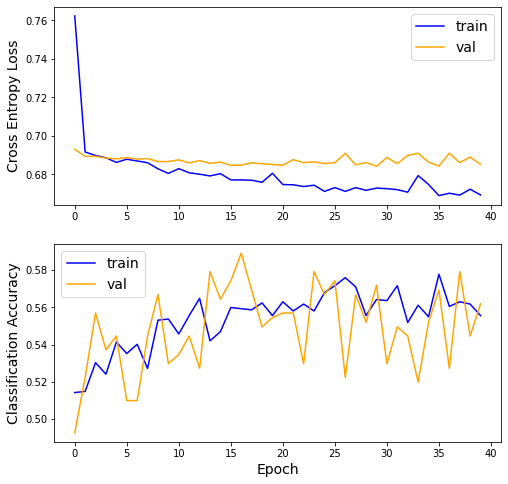

In [153]:
summarize_diagnostics(history_twovgg_dataaug)


Didn't help. Why isn't the training set accuracy increasing like it was without data augmentation? 

In [166]:
# define cnn model
def three_vggblock_batchnorm(input_shape):
    model = Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255,input_shape=input_shape))
    model.add(layers.experimental.preprocessing.RandomFlip("horizontal"))
    model.add(layers.experimental.preprocessing.RandomRotation(0.1))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [169]:
history_threevgg_batchnorm = run_test_harness('three_vggblock_batchnorm',three_vggblock_batchnorm,epochs=50)

Input shape: (100, 100, 3)
Found 2024 files belonging to 2 classes.
Using 1620 files for training.
Found 2024 files belonging to 2 classes.
Using 404 files for validation.
Found 419 files belonging to 2 classes.
Epoch 1/50
51/51 [==============================] - 26s 485ms/step - loss: 1.0003 - accuracy: 0.5151 - val_loss: 0.7209 - val_accuracy: 0.4752
Epoch 2/50
51/51 [==============================] - 25s 480ms/step - loss: 0.8730 - accuracy: 0.5304 - val_loss: 0.7808 - val_accuracy: 0.5545
Epoch 3/50
51/51 [==============================] - 24s 479ms/step - loss: 0.7844 - accuracy: 0.5492 - val_loss: 0.7724 - val_accuracy: 0.5421
Epoch 4/50
51/51 [==============================] - 25s 481ms/step - loss: 0.7414 - accuracy: 0.5381 - val_loss: 0.8584 - val_accuracy: 0.5470
Epoch 5/50
51/51 [==============================] - 25s 481ms/step - loss: 0.7229 - accuracy: 0.5550 - val_loss: 0.9526 - val_accuracy: 0.5619
Epoch 6/50
51/51 [==============================] - 25s 483ms/step - loss

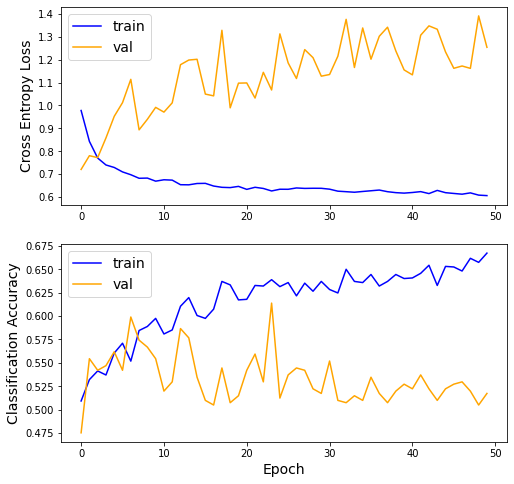

In [170]:
summarize_diagnostics(history_threevgg_batchnorm)

Interesting that it is still wildly overfitting even with dropouts, data augmentation and batchnorm. It's possible this model just is not flexible enough to capture the complexity in our data. 

In [173]:
# define cnn model to be a hybrid between VGG and Xception
def test(input_shape):
    model = Sequential()
    
    model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255,input_shape=input_shape))
    model.add(layers.experimental.preprocessing.RandomFlip("horizontal"))
    model.add(layers.experimental.preprocessing.RandomRotation(0.1))
    
    model.add(Conv2D(32, 3,strides=2, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, 3,strides=2, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3, strides=2, padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, 3,strides=2, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3,strides=2, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3, strides=2, padding="same"))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, 3,strides=2, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3,strides=2, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(3, strides=2, padding="same"))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [174]:
history_test = run_test_harness('test',test,epochs=50)

Input shape: (100, 100, 3)
Found 2024 files belonging to 2 classes.
Using 1620 files for training.
Found 2024 files belonging to 2 classes.
Using 404 files for validation.
Found 419 files belonging to 2 classes.
Epoch 1/50
51/51 [==============================] - 3s 36ms/step - loss: 1.0235 - accuracy: 0.5194 - val_loss: 0.7075 - val_accuracy: 0.4926
Epoch 2/50
51/51 [==============================] - 2s 34ms/step - loss: 0.9372 - accuracy: 0.5136 - val_loss: 0.7160 - val_accuracy: 0.4926
Epoch 3/50
51/51 [==============================] - 2s 34ms/step - loss: 0.8506 - accuracy: 0.5132 - val_loss: 0.7131 - val_accuracy: 0.4926
Epoch 4/50
51/51 [==============================] - 2s 33ms/step - loss: 0.8080 - accuracy: 0.4964 - val_loss: 0.7054 - val_accuracy: 0.5050
Epoch 5/50
51/51 [==============================] - 2s 33ms/step - loss: 0.7933 - accuracy: 0.5019 - val_loss: 0.6975 - val_accuracy: 0.5223
Epoch 6/50
51/51 [==============================] - 2s 33ms/step - loss: 0.7698 - a

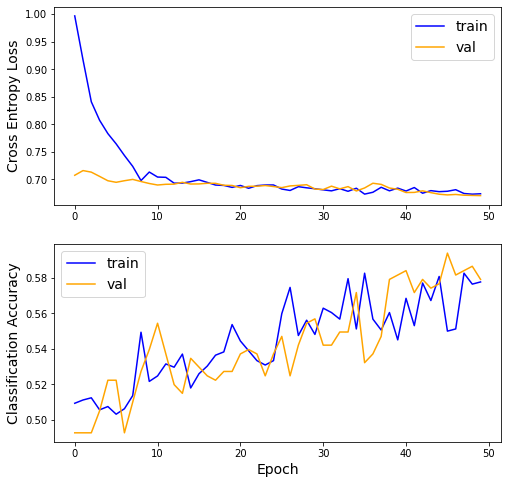

In [177]:
summarize_diagnostics(history_test)

In [178]:
# Keep training this model -- looks like it could still improve
last_file = '../baseline_model/cnn_saved_epochs/test/model_epoch_50.h5'
last_model = keras.models.load_model(last_file)
model_name='test'
image_size = (100,100)
n_channels = 3
input_shape = image_size + (n_channels,)
batch_size = 32
epochs = 25
train_ds, val_ds = load_dataset(batch_size=batch_size,image_size=image_size)
test_ds = load_testset(batch_size=batch_size,image_size=image_size)
# Prefetch data -- this will preload other batches' data while current batch data are being processed
# might only work with GPU but worth including
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)    
# define model
# fit model
savedir = os.path.join('../baseline_model','cnn_saved_epochs',model_name)
if not os.path.exists(savedir):
    os.mkdir(savedir)
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(savedir,"model_epoch_{epoch}_contd.h5")),
]

history_test_contd = last_model.fit(
train_ds, 
epochs=epochs,
callbacks=callbacks,
validation_data=val_ds)
    # find best model -

Found 2024 files belonging to 2 classes.
Using 1620 files for training.
Found 2024 files belonging to 2 classes.
Using 404 files for validation.
Found 419 files belonging to 2 classes.
Epoch 1/25
51/51 [==============================] - 2s 36ms/step - loss: 0.6754 - accuracy: 0.5772 - val_loss: 0.6755 - val_accuracy: 0.5693
Epoch 2/25
51/51 [==============================] - 2s 32ms/step - loss: 0.6750 - accuracy: 0.5821 - val_loss: 0.6827 - val_accuracy: 0.5594
Epoch 3/25
51/51 [==============================] - 2s 32ms/step - loss: 0.6768 - accuracy: 0.5679 - val_loss: 0.6900 - val_accuracy: 0.5347
Epoch 4/25
51/51 [==============================] - 2s 33ms/step - loss: 0.6729 - accuracy: 0.5877 - val_loss: 0.6779 - val_accuracy: 0.5718
Epoch 5/25
51/51 [==============================] - 2s 34ms/step - loss: 0.6705 - accuracy: 0.5827 - val_loss: 0.6754 - val_accuracy: 0.5817
Epoch 6/25
51/51 [==============================] - 2s 33ms/step - loss: 0.6766 - accuracy: 0.5741 - val_loss:

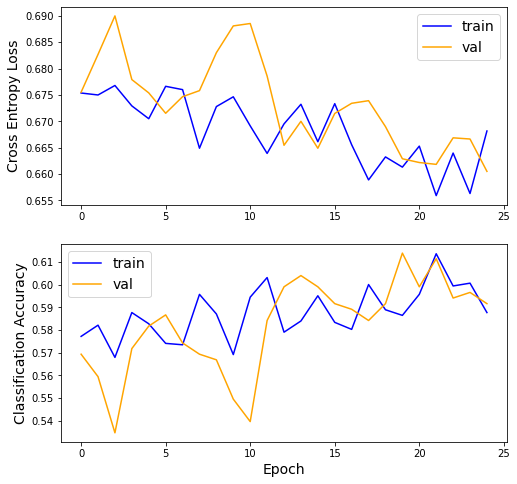

In [179]:
summarize_diagnostics(history_test_contd)

In [180]:
# Keep training this model -- looks like it could still improve
last_file = '../baseline_model/cnn_saved_epochs/test/model_epoch_25_contd.h5'
last_model = keras.models.load_model(last_file)
model_name='test'
image_size = (100,100)
n_channels = 3
input_shape = image_size + (n_channels,)
batch_size = 32
epochs = 50
train_ds, val_ds = load_dataset(batch_size=batch_size,image_size=image_size)
test_ds = load_testset(batch_size=batch_size,image_size=image_size)
# Prefetch data -- this will preload other batches' data while current batch data are being processed
# might only work with GPU but worth including
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)    
# define model
# fit model
savedir = os.path.join('../baseline_model','cnn_saved_epochs',model_name)
if not os.path.exists(savedir):
    os.mkdir(savedir)
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(savedir,"model_epoch_{epoch}_contd2.h5")),
]

history_test_contd = last_model.fit(
train_ds, 
epochs=epochs,
callbacks=callbacks,
validation_data=val_ds)

Found 2024 files belonging to 2 classes.
Using 1620 files for training.
Found 2024 files belonging to 2 classes.
Using 404 files for validation.
Found 419 files belonging to 2 classes.
Epoch 1/50
51/51 [==============================] - 2s 35ms/step - loss: 0.6639 - accuracy: 0.6000 - val_loss: 0.6580 - val_accuracy: 0.6188
Epoch 2/50
51/51 [==============================] - 2s 34ms/step - loss: 0.6649 - accuracy: 0.6136 - val_loss: 0.6709 - val_accuracy: 0.5990
Epoch 3/50
51/51 [==============================] - 2s 33ms/step - loss: 0.6642 - accuracy: 0.5988 - val_loss: 0.6687 - val_accuracy: 0.5842
Epoch 4/50
51/51 [==============================] - 2s 34ms/step - loss: 0.6640 - accuracy: 0.5883 - val_loss: 0.6608 - val_accuracy: 0.6188
Epoch 5/50
51/51 [==============================] - 2s 33ms/step - loss: 0.6664 - accuracy: 0.5840 - val_loss: 0.6685 - val_accuracy: 0.5916
Epoch 6/50
51/51 [==============================] - 2s 33ms/step - loss: 0.6594 - accuracy: 0.6117 - val_loss:

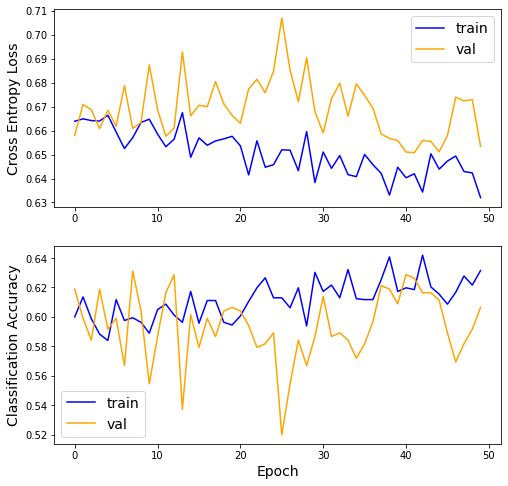

In [181]:
summarize_diagnostics(history_test_contd)

In [41]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """
    Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve.
    ---INPUT---
    predictions:    predicted classes in the test set
    
    """
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model (test set)')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [39]:
train_predictions = []
train_labels = []
train_probs = []
for x, y in train_ds:
    new_predictions = best_model.predict(x)[:,0]
    train_predictions.extend(list(map(round,new_predictions)))
    train_labels.extend(list(map(round,y.numpy())))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        train_probs.append(pred_float)
    


Recall Baseline: 1.0 Test: 0.86 Train: 0.92
Precision Baseline: 0.48 Test: 0.84 Train: 0.87
Roc Baseline: 0.5 Test: 0.94 Train: 0.96


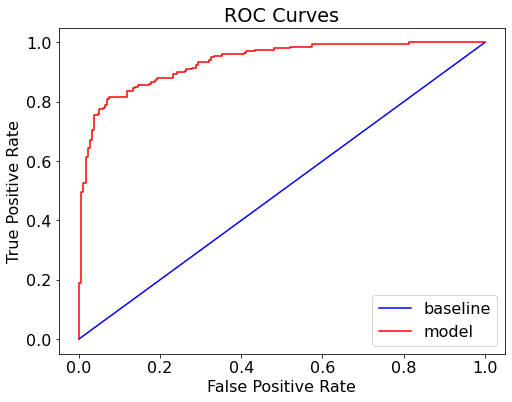

In [40]:
evaluate_model(test_predictions,test_probs,train_predictions, train_probs)

This is about what I got for the titanic survival challenge which isn't bad!

Let's look at some false positives.

These have a similar background color to the true positives, so it might be using background color here. Another reason to use grayscale instead of color images. 

In [253]:
true_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_negatives.append(fn_dict)

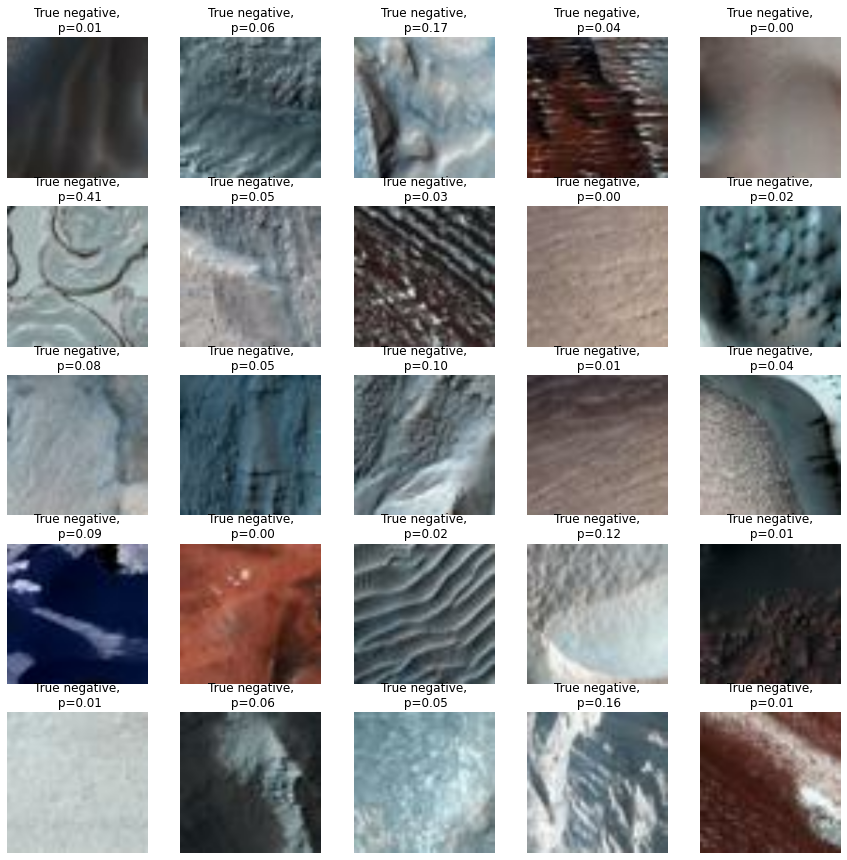

In [256]:
# inspect true negative
plt.figure(figsize=(15, 15))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = true_negatives[i]['pred']
    plt.title(f"True negative,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

In [257]:
# Save best model
best_model.save('../cnn_saved_epochs/best_model_epoch53.h5')

## Things to do
- Run the model on the rest of the dataset.
- A bigger training/validation set. It's pretty amazing it is doing as well as it is given the limited size of the training set I used.
- Try using grayscale images instead of color. Color might be throwing off the model. 
- Figure out how to do cross validation with this kind of model
- Keras tuner
- Try different CNN architectures
- Try use_multiprocessing=True in model.fit() to see if we get improvement
- Try different image sizes to see if that helps/hurts training
- Purify training/val set to only include obvious craters
- Learn how to look at the intermediate filters in my model

## Done
- Make a test set and evaluate the model on that -- Take a look at confusion matrix/ ROC-AUC curve
